In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from scipy.optimize import curve_fit
from tqdm.auto import trange
from tqdm import tqdm
import Metropolis_Algorithm as MA

import importlib

importlib.reload(MA)

# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 130  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

In [2]:
# Potential
def x_potential(x):
    return 1/2 * x**2

def y_potential(x):
    return 1000 * x**4

def ho_analytic_pdf(x):
    return (1 / np.sqrt(np.pi)) * np.exp(-x**2)

def residual_calculator(x_values, model, model_parameters, y_values, y_errors):
    theoretical_values = model(x_values, *model_parameters)
    residuals = (y_values - theoretical_values)/y_errors
    return residuals

In [ ]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_x = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 1.8437008005694266
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x ** 2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.7616 (expected ≈ 0.707)
Root mean square: 0.7616 (expected ≈ 0.707)


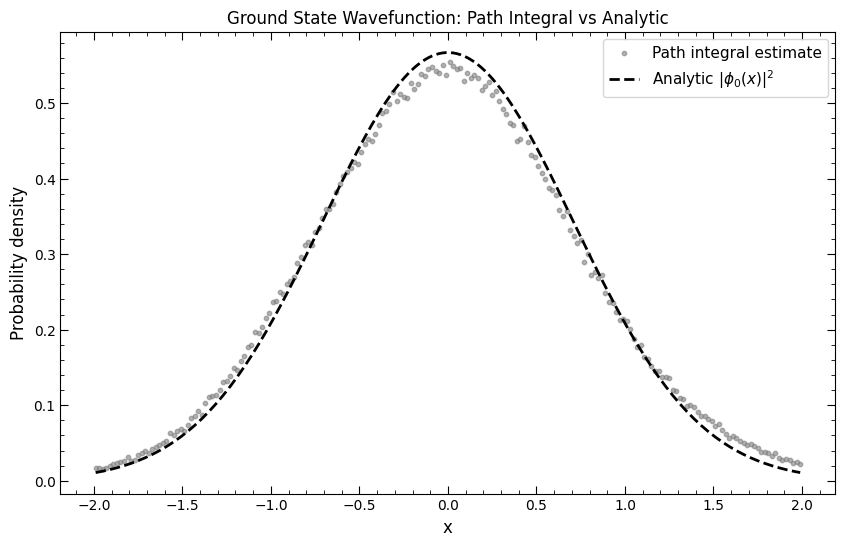

In [11]:
pc_savepath_metropolis_groundstate = r"C:\Users\User\Documents\Durham Work\Year 3\CompPhys\metropolis_groundstate.svg"

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color='grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black', linestyle='--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.savefig(pc_savepath_metropolis_groundstate, bbox_inches='tight')
plt.show()